<a href="https://colab.research.google.com/github/dookda/cmu_py499/blob/main/gee_meji_usc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthengine-api
!pip install geemap folium

# Authenticate and initialize the Earth Engine API
import ee

# Provide your Google Cloud project ID
project_id = 'earthengine-380405'

# Authenticate and initialize the Earth Engine API with the project ID
ee.Authenticate()
ee.Initialize(project=project_id)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!rm -r '/content/drive/MyDrive/_DATASET/meji_usc.csv'

In [2]:
import ee
import folium
import geemap

ee.Initialize()

hex150 = ee.FeatureCollection("projects/earthengine-380405/assets/hex150tb_4326");
site = hex150.geometry().bounds()

start_date = '2024-01-01'
end_date = '2024-01-31'

In [6]:
import ee
import folium
import geemap

def get_min(img, geom):
    min_val = img.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=geom,
        scale=100,
        maxPixels=1e9
    ).getInfo()
    return min_val['constant']

def get_max(img, geom):
    max_val = img.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=geom,
        scale=100,
        maxPixels=1e9
    ).getInfo()
    return max_val['constant']

def rename_property(feature, params):
    mean_value = feature.get('mean')
    feature = feature.set(params, mean_value)
    feature = feature.set('mean', None)
    return feature

def zonal_stat(image, geom, params):
    z_stats = image.reduceRegions(
        collection=geom,
        reducer=ee.Reducer.mean(),
        scale=100,
        tileScale=1,
        crs='EPSG:4326'
    )
    feat = z_stats.map(lambda feature: rename_property(feature, params))
    # show_scatter_plot(feat, params)
    return feat

def kelvin_to_celsius(img):
    return img.multiply(0.02).subtract(273.15).rename('LST_Celsius')

def prepare_data(image):
    proj = image.reproject(
        crs="EPSG:32647",
        scale=100
    )
    clip_img = proj.clip(site)
    return clip_img

def show_scatter_plot(feat, params):
    scatter_plot = geemap.ee_chart_by_feature(
        ee.FeatureCollection(feat), x_property=params, y_properties=['usc'], chart_type='ScatterChart',
        options={
            'title': 'Scatter Plot of ' + params + ' vs usc',
            'hAxis': {'title': params},
            'vAxis': {'title': 'usc'},
            'pointSize': 5
        }
    )
    scatter_plot.show()

# load S5P
O3 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_O3") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .select('O3_column_number_density') \
    .median()

SO2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .select('SO2_column_number_density') \
    .median()

AER_LH = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_AER_LH") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .select('aerosol_optical_depth') \
    .median()

CH4 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CH4") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .select('CH4_column_volume_mixing_ratio_dry_air') \
    .median()

HCHO = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_HCHO") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .select('tropospheric_HCHO_column_number_density') \
    .median()

NO2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .select('NO2_column_number_density') \
    .median()

CO = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .select('CO_column_number_density') \
    .median()

NDVI = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .median() \
    .normalizedDifference(["B8", "B4"])

LST = ee.ImageCollection("MODIS/061/MOD11A1") \
    .filterBounds(site) \
    .filterDate(start_date, end_date) \
    .select('LST_Day_1km') \
    .map(kelvin_to_celsius) \
    .median()

In [ ]:
# Dependence layer
lst = zonal_stat(LST, hex150, 'lst')
ndvi = zonal_stat(NDVI, lst, 'ndvi')
o3 = zonal_stat(O3, ndvi, 'o3')
so2 = zonal_stat(SO2, o3, 'so2')
aer_lh = zonal_stat(AER_LH, so2, 'aer_lh')
ch4 = zonal_stat(CH4, aer_lh, 'ch4')
hcho = zonal_stat(HCHO, ch4, 'hcho')
co = zonal_stat(CO, hcho, 'co')
no2 = zonal_stat(NO2, co, 'no2')

# Create map
map_center = [18.80, 99]
f = folium.Figure(height=400)
m = folium.Map(location=map_center, zoom_start=12).add_to(f)

google_satellite = folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

def showMap(feat, geom, param):
  empty = ee.Image().byte()
  imageUsc = empty.paint( featureCollection=feat, color=param)
  visualization = {
      'min': get_min(imageUsc, geom),
      'max': get_max(imageUsc, geom),
      'palette': ['green', 'yellow', 'red']
  }

  map_id_dict = ee.Image(imageUsc).getMapId(visualization)
  folium.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=param,
      overlay=True,
      control=True,
      opacity=0.5
  ).add_to(m)

showMap(co, site, 'usc')
showMap(no2, site, 'no2')
showMap(ndvi, site, 'ndvi')
showMap(lst, site, 'lst')
showMap(o3, site, 'o3')

folium.LayerControl().add_to(m)
m


In [ ]:
# Export to Drive
export_task = ee.batch.Export.table.toDrive(
    collection=no2,
    description='zonal_statistics',
    folder='_DATASET',
    fileNamePrefix='meji_usc2',
    fileFormat='CSV'
)
export_task.start()

Index(['system:index', 'bd_h', 'bottom', 'co', 'col_index', 'id', 'left',
       'mean', 'ndvi', 'no2', 'o3', 'right', 'road_w', 'row_index', 'so2',
       'top', 'usc', '.geo'],
      dtype='object')
            bd_h        co       no2        o3    road_w       so2       usc  \
bd_h    1.000000  0.234833 -0.200507 -0.355229  0.032847 -0.094250  0.843046   
co      0.234833  1.000000  0.374725 -0.437730 -0.062990  0.486627  0.211907   
no2    -0.200507  0.374725  1.000000 -0.081499 -0.102399  0.846837 -0.118145   
o3     -0.355229 -0.437730 -0.081499  1.000000  0.160894 -0.302869 -0.369145   
road_w  0.032847 -0.062990 -0.102399  0.160894  1.000000 -0.086445 -0.456719   
so2    -0.094250  0.486627  0.846837 -0.302869 -0.086445  1.000000 -0.038192   
usc     0.843046  0.211907 -0.118145 -0.369145 -0.456719 -0.038192  1.000000   
ndvi   -0.348102 -0.119334  0.063737  0.159633 -0.273710  0.001765 -0.146500   

            ndvi  
bd_h   -0.348102  
co     -0.119334  
no2     0.063737  
o3

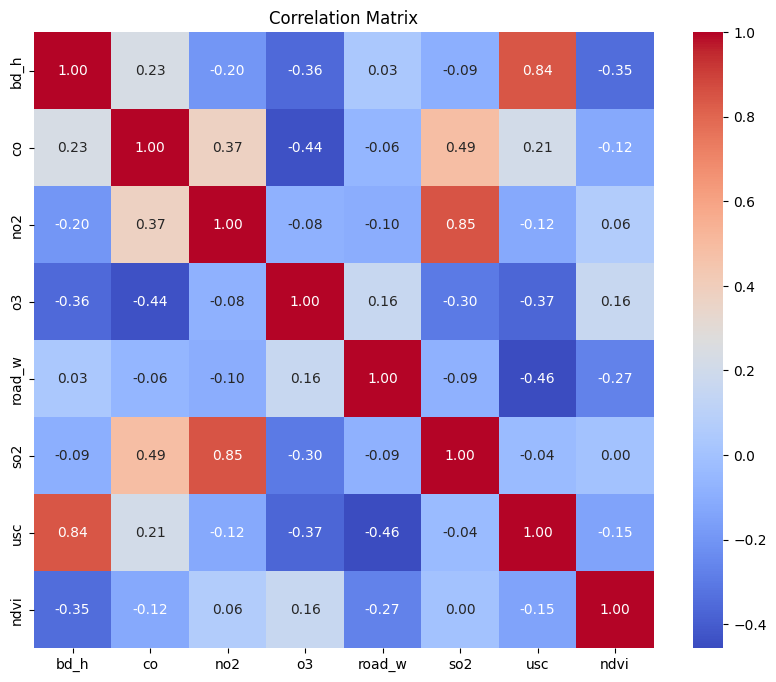

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'ndvi_z_test18_04.csv'

df = pd.read_csv(file_path)
print(df.columns)
columns_of_interest = ['bd_h', 'co', 'no2', 'o3', 'road_w','so2', 'usc', 'ndvi']

correlation_matrix = df[columns_of_interest].corr()
print(correlation_matrix)
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [1]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
# from google.colab import drive
from sklearn.model_selection import train_test_split

# Mount Google Drive
# drive.mount('/content/drive')

file_path = '2021-45_edit.csv'

df = pd.read_csv(file_path)
df = df.dropna(subset= ['usc', 'ndvi'])

if df.shape[0] == 0:
    raise ValueError("No samples available after dropping rows with null values.")

target_variable = 'co'
columns_of_interest =  ['usc', 'ndvi']

X = df[columns_of_interest]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Forward stepwise regression
def forward_stepwise_selection(X, y):
    initial_features = []
    remaining_features = list(X.columns)
    best_features = []
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            features = initial_features + [candidate]
            X_train_with_candidate = sm.add_constant(X[features])
            model = sm.OLS(y, X_train_with_candidate).fit()
            score = model.rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]
        if initial_features:
            best_old_score = sm.OLS(y, sm.add_constant(X[initial_features])).fit().rsquared_adj
            if best_new_score <= best_old_score:
                break
        initial_features.append(best_candidate)
        remaining_features.remove(best_candidate)
        best_features.append((best_new_score, best_candidate))
    return best_features

# Perform forward stepwise selection
best_features = forward_stepwise_selection(X_train, y_train)

# Print the selected features and their scores
print("Selected features and their adjusted R-squared scores:")
for score, feature in best_features:
    print(f"{feature}: {score}")

# Build the final model with the selected features
selected_features = [feature for _, feature in best_features]
X_train_selected = sm.add_constant(X_train[selected_features])
X_test_selected = sm.add_constant(X_test[selected_features])
final_model = sm.OLS(y_train, X_train_selected).fit()

# Print the summary of the final model
print(final_model.summary())

# Evaluate the model on the test set
y_pred = final_model.predict(X_test_selected)
print(f"Test set R-squared: {final_model.rsquared}")


FileNotFoundError: [Errno 2] No such file or directory: '2021-45_edit.csv'